In [95]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'inferno'
%run functions.ipynb

-1 380 380
-1
(380, 380)


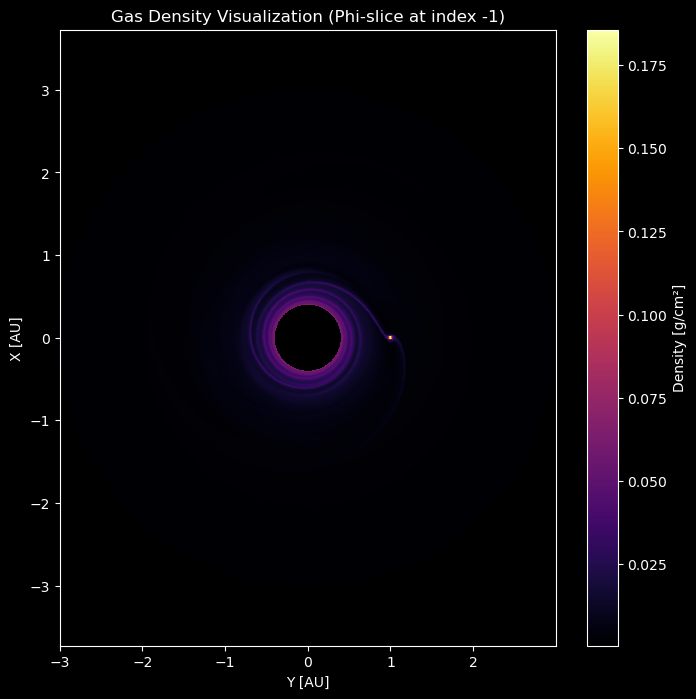

In [99]:
import numpy as np
import matplotlib.pyplot as plt

slice = 2
i= slice


# Load the gas density data from the file
data = np.fromfile(f'/home/jupitergeci/fargo3d/outputs/fargo_sizes/gasdens{i:01d}.dat', 				dtype=np.float64)

# Load the domain_x.dat, domain_y.dat, and domain_z.dat files
domain_x = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_x.dat')        # coordenada azimuthal theta
domain_y = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_y.dat')[3:-3]  # coordenada radial r
domain_z = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_z.dat')[3:-3]  # coordenada co-latitud phi

# Get the dimensions of the data grid
NZ, NY, NX = len(domain_z)-1, len(domain_y)-1, len(domain_x)-1

print(NZ, NY, NX)

# Reshape the data array to match the dimensions of the grid
data = data.reshape(NZ, NY, NX)

# Select a slice along the phi-axis (the first dimension)
slice_index = NZ // 2  # Middle of the phi-axis
data_slice = data[slice_index, :, :]

# Define functions to create the X, Y, and Z grids
def Grilla_XY():
    # Create 2D grids
    R = 0.5 * (domain_y[1:] + domain_y[:-1])
    Phi = 0.5 * (domain_x[1:] + domain_x[:-1]) #En Fargo theta (azimuth) -> phi (coodenada X)
    P, R = np.meshgrid(Phi, R)
    # Convert the cylindrical coordinates (R, P) to Cartesian coordinates (X, Y)
    X, Y = R*np.cos(P), R*np.sin(P)
    return X, Y


X,Y = Grilla_XY()

# Select a slice along the phi-axis (the first dimension)

top = int( NZ // 1)- 1  # top of the phi-axis
mid = NZ // 2          # Middle of the phi-axis
slice_index = mid # Dónde se hace el corte
print(slice_index)
data_slice = data[slice_index, :, :]

print(X.shape)

# Plot the data in Cartesian coordinates
plt.figure(figsize=(8, 8))
plt.pcolormesh(X, Y, data_slice, cmap='inferno')
plt.colorbar(label='Density [g/cm²]')
plt.title(f'Gas Density Visualization (Phi-slice at index {slice_index})')
plt.xlabel('Y [AU]')
plt.ylabel('X [AU]')
plt.style.use("dark_background")
plt.axis('equal')
 
plt.show()

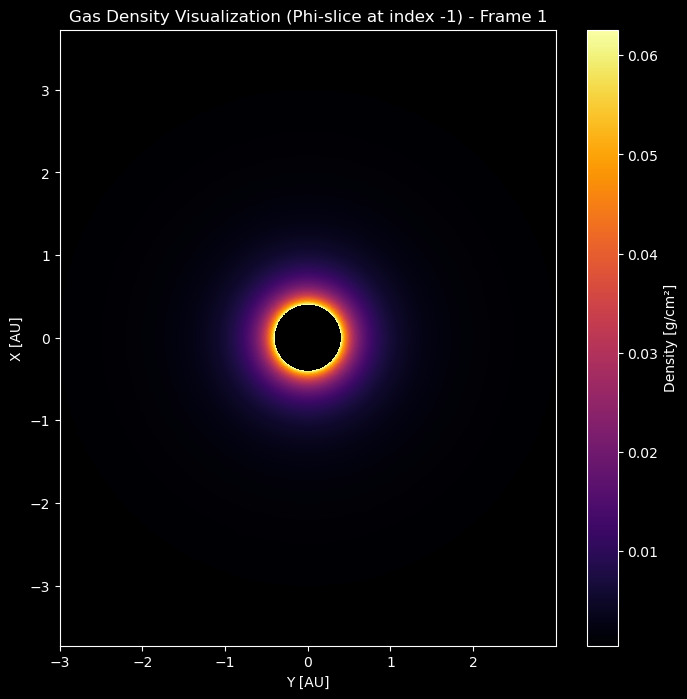

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import warnings

# Ignorar todas las advertencias
warnings.filterwarnings("ignore")
def update_plot(frame):
    """Actualiza la gráfica para el frame actual."""

    # Carga los datos para el frame actual
    data = np.fromfile(f'/home/jupitergeci/fargo3d/outputs/fargo_sizes/gasdens{frame:01d}.dat', dtype=np.float64)
    data = data.reshape(NZ, NY, NX)
    data_slice = data[slice_index, :, :]

    # Limpia la gráfica anterior
    plt.clf()

    # Crea la nueva gráfica
    plt.pcolormesh(X, Y, data_slice, cmap='inferno')
    plt.colorbar(label='Density [g/cm²]')
    plt.title(f'Gas Density Visualization (Phi-slice at index {slice_index}) - Frame {frame+1}')
    plt.xlabel('Y [AU]')
    plt.ylabel('X [AU]')
    plt.axis('equal')
    plt.style.use("dark_background")

    return plt.gcf(),

# Carga los datos del grid una sola vez
domain_x = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_x.dat')
domain_y = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_y.dat')[3:-3]
domain_z = np.genfromtxt('/home/jupitergeci/fargo3d/outputs/fargo_sizes/domain_z.dat')[3:-3]
NZ, NY, NX = len(domain_z)-1, len(domain_y)-1, len(domain_x)-1
slice_index = NZ // 2
X, Y = Grilla_XY()

# Crea la animación
fig = plt.figure(figsize=(8, 8),facecolor="black")
anim = FuncAnimation(fig, update_plot, frames=slice, interval=200)  # 3 frames, intervalo de 200 ms
# Guarda la animación como GIF
anim.save('gas_density_visualization.gif', writer='imagemagick')

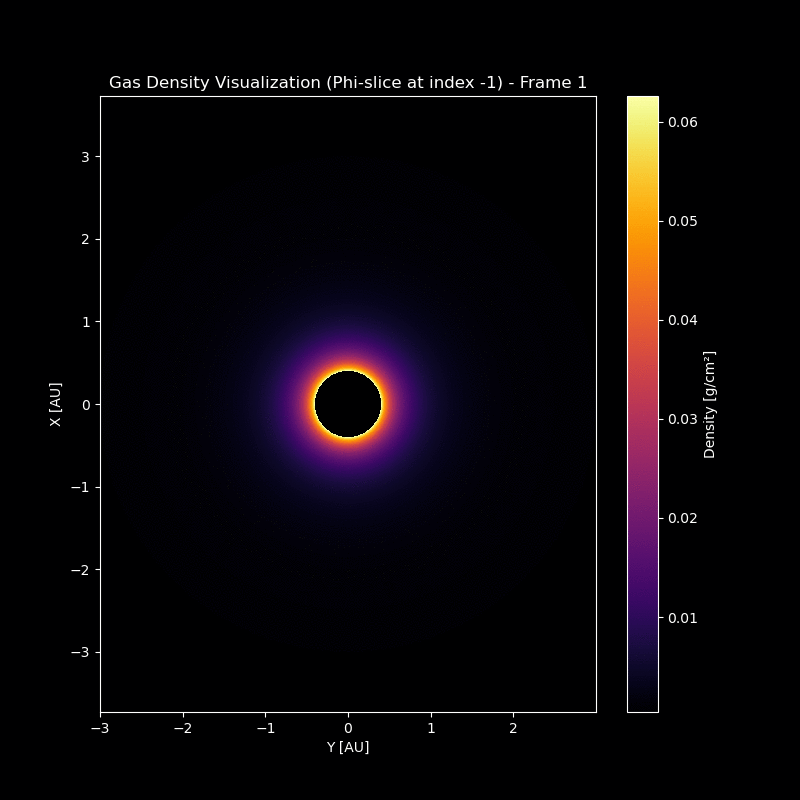

In [103]:
from IPython.display import Image

# Carga el GIF
gif = open('gas_density_visualization.gif', 'rb').read()

# Muestra el GIF como una imagen
Image(gif)

Functions to read grid and parameters of FARGO3D

In [104]:
class read_parameters():
    def __init__(self, path=''):
        params = open(path+"variables.par",'r')
        lines = params.readlines()     # reading parfile                                                                                                                                       
        params.close()                 # closing parfile                                                                                                                                       
        par = {}                       # allocating a dictionary                                                                                                                               
        for line in lines:             # iterating over parfile                                                                                                                                
            name, value = line.split() # spliting name and value (first blank)                                                                                                                 
            try:
                float(value)           # first trying with float                                                                                                                               
            except ValueError:         # if it is not float                                                                                                                                    
                try:
                    int(value)         # we try with integer                                                                                                                                   
                except ValueError:     # if it is not integer, we know it is string                                                                                                            
                    value = '"' + value + '"'
            par[name] = value          # filling variable                                                                                                                                      
        self._params = par             # control atribute, good for debbuging                                                                                                                  
        for name in par:               # iterating over the dictionary                                                                                                                         
            exec("self."+name.lower()+"="+par[name]) # making atributes at runtime

class hydro_grid():
    def __init__(self,path=""):
        try:
            self.x = np.loadtxt(path+"domain_x.dat")+np.pi # AZIMUTH                                                                                                                          
        except IOError:
            print("IOError with domain_x.dat")
        try:
            self.y = np.loadtxt(path+"domain_y.dat")[3:-3] # RADIUS                                                                                                                     
        except IOError:
            print("IOError with domain_y.dat")
        try:
            self.z = np.loadtxt(path+"domain_z.dat")[3:-3] # COLATITUDE                                                                                                                 
        except:
            print("No vertical domain found - Is the simulation 2D?")

Load densities from FARGO3D output folder 'fargodir'

[0.01, 0.0316227766016838, 0.1]


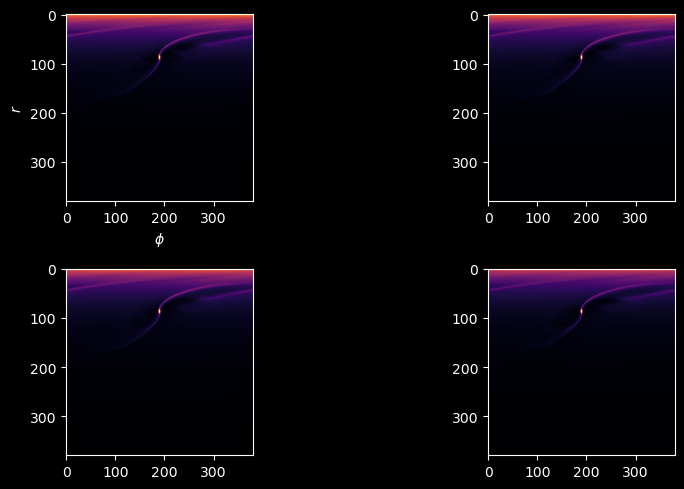

In [105]:
au = 1.5e13 # centimetros
msun= 2e33  # gramos


fargodir = "/home/jupitergeci/fargo3d/outputs/fargo_sizes/"
t = 1
par = read_parameters(path=fargodir)
gridF = hydro_grid(path=fargodir)
ndust = 3
names = ['gas','dust1','dust2','dust3']
dens = []
sizes= []
St   = []
dens.append(np.fromfile(fargodir+'gasdens%d.dat'%t).reshape(par.ny,par.nx))
for i in range(1,ndust+1):
    dens.append(np.fromfile(fargodir+names[i]+'dens%d.dat'%t).reshape(par.ny,par.nx))
    dens[i-1] *= par.mfactor*msun/(par.rfactor*au)**2
    sizes.append(par.amin*pow((par.amax/par.amin),(i-1.0)/(ndust-1.0)))
    St.append(np.pi/2.0*sizes[i-1]*par.rho_solid/dens[0])
print(sizes)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,5))
ax1.imshow(dens[0],vmax = dens[0].max()/2)
ax2.imshow(dens[1],vmax = dens[1].max()/2)
ax3.imshow(dens[2],vmax = dens[2].max()/2)
ax4.imshow(dens[3],vmax = dens[3].max()/2)

ax1.set_xlabel(r'$\phi$')
ax1.set_ylabel(r'$r$')
plt.tight_layout()
plt.show()

Set up the RADMC-3D grid

In [106]:
###Define grid similar to introduction but including the polar direction with theta = [pi/2-0.3,pi/2]###
class grid:
    def __init__(self,dims,bounds):
        self.nr, self.ntheta, self.nphi = dims[0],dims[1],dims[2]
        self.use_r  = 1 if self.nr > 1 else 0     # Which directions are included? 
        self.use_theta = 1 if self.ntheta > 1 else 0
        self.use_phi = 1 if self.nphi > 1 else 0
        self.theta_face = np.linspace(bounds[2],bounds[3],self.ntheta+1)
        self.theta = 0.5*(self.theta_face[1:]+self.theta_face[:-1])
        
r_in, r_out = par.ymin*par.rfactor*au, par.ymax*par.rfactor*au
if par.nz == 1:
    theta_up,theta_down = np.pi/2-0.3,np.pi/2+0.3
phi_l, phi_r = par.xmin,par.xmax
bounds = [r_in,r_out,theta_up,theta_down,phi_l,phi_r]
grid1 = grid([par.ny,50,par.nx],bounds) # This produces a 1D grid with 100 cells in radial direction
grid1.r0 = par.rfactor*au
grid1.r_face = gridF.y*grid1.r0
grid1.r = 0.5*(grid1.r_face[1:]+grid1.r_face[:-1])
grid1.phi_face   = gridF.x
grid1.phi = 0.5*(grid1.phi_face[1:]+grid1.phi_face[:-1])
grid_inp(grid1)                # this writes a file called 'amr_grid.inp' needed to run RADMC-3D

Expand the density in vertical direction and conform the fields to the RADMC-3D style

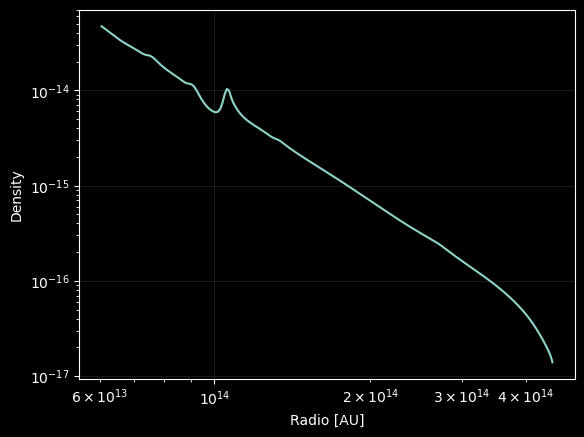

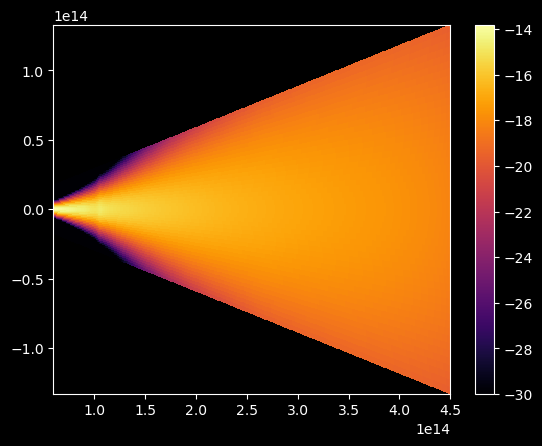

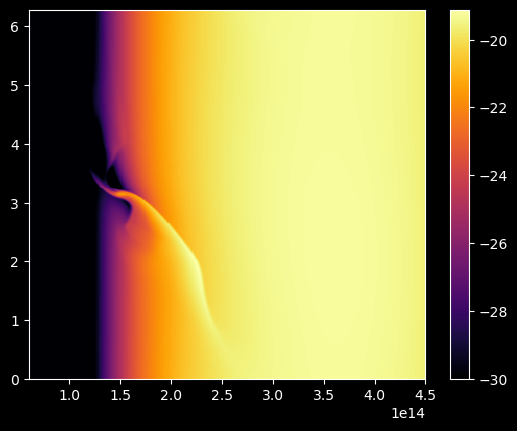

In [107]:
H0 = par.aspectratio*grid1.r0
f = par.flaringindex

coord       = np.meshgrid(grid1.r,grid1.theta,grid1.phi,indexing='ij')
rr       = coord[0] # centimetros
tt       = coord[1] # rad
pp       = coord[2] # rad
z        = np.cos(tt)*rr # centimetros

rho = []
for i in range(ndust):
    S_2d  = dens[i+1]
    S_3d  = np.zeros_like(rr)
    H_2d  = H0*(grid1.r/grid1.r0)**(1+f)
    H_2d  = np.meshgrid(H_2d,grid1.phi,indexing='ij')
    H_2d  = H_2d[0]
    H_2d *= np.sqrt(par.alpha/(par.alpha+St[i][:,:]))
    H_3d  = np.zeros_like(rr)
    for it in range(grid1.ntheta):
        S_3d[:,it,:] = S_2d[:,:]
        H_3d[:,it,:] = H_2d[:,:]
    rho.append(( S_3d / (np.sqrt(2.0*np.pi)*H_3d) ) * np.exp(-(z**2/H_3d**2)/2.0))


rho = np.array(rho)
plt.loglog(grid1.r,rho[0,:,:,0].sum(axis=-1))
plt.xlabel("Radio [AU]")
plt.ylabel("Density")
plt.grid(alpha=0.1)
plt.show()

plt.pcolormesh(rr[:,:,0],z[:,:,0],np.log10(rho[0,:,:,0]),vmin=-30)
plt.colorbar()
plt.show()

plt.pcolormesh(rr[:,0,:],pp[:,0,:],np.log10(rho[0,:,0,:]),vmin=-30)
plt.colorbar()
plt.show()

Write the density to file

In [108]:
dens_inp(grid1,rho,ndust)

Create the input files *wavelength_micron.inp*, *stars.inp*, *dustopac.inp*, *dustkappa_\*.inp* and *radmc3d.inp*

In [109]:
class wavelength:
    def __init__(self,lmin,lmax,nl):
        self.lmin = lmin
        self.lmax = lmax
        self.nlam = nl
        self.lam  = np.logspace(np.log10(lmin),np.log10(lmax),nl)
        
wl = wavelength(0.1,1e4,10)
wavelength_inp(wl) # this creates an input file called 'wavelength_micron.inp'

In [110]:
class stars:
    def __init__(self,p,T,R,M):
        self.x,self.y,self.z = p[0], p[1], p[2]
        self.T = T
        self.R = R
        self.M = M
        
allstars = []
Star1 = stars([0,0,0],6000.0,7e10,2e33)
allstars.append(Star1)
stars_inp(allstars,wl) # this creates a file 'stars.inp'

Optool its a independ library which we can reproduce specific composition of the material in the disk

In [111]:
ls


 amr_grid.inp              'FARGO3D to RADMC-3D.ipynb'
 dust_density.inp           functions.ipynb
 dustkappa_dust1.inp        gas_density_visualization.gif
 dustkappa_dust2.inp        image.out
 dustkappa_dust3.inp        ppd.ipynb
 dustkapscatmat_dust1.inp   radmc3d.inp
 dustkapscatmat_dust2.inp   radmc3d.out
 dustkapscatmat_dust3.inp   spectrum.out
 dustkapscatmat.inp         stars.inp
 dustopac.inp               wavelength_micron.inp
 dust_temperature.dat


In [112]:
dustopac_inp(names[1:]) # this creates a file called 'dustopac.inp'. The main purpose of this file is to
                         # tell the code how many dust species there are and where to find the according
                         # opacities

In [113]:
nphot_therm = 1e7
nphot_scat  = 1e6
nphot_spec  = 1e4
scattering_mode_max = 1
nthreads=8
radmc3d_inp(nphot_therm,nphot_scat,nphot_spec,
            scattering_mode_max,nthreads,mrw=0) # this creates a file called 'radmc3d.inp'
                                 # which more generally defines how the code
                                 # will be executed and which methods will
                                 # be employed.

Run the command to calculate the disk temperature and make a colormap of the temperature in the disk. 

In [ ]:
! radmc3d mctherm secondorder

Generate the spectral energy distribution (SED) of the disk and plot it. Can you identify certain contributions to the SED?

In [ ]:
! radmc3d sed incl 96.0

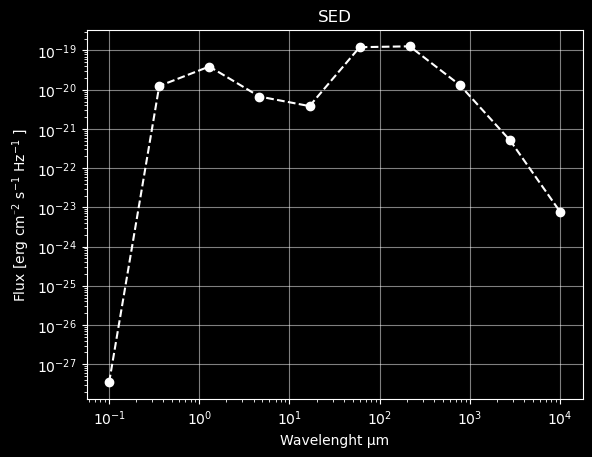

In [116]:
wls, sed = read_spectrum('spectrum.out',wl)
plt.title("SED")
plt.loglog(wls,sed,c='white', marker="o",linestyle="--")
#plt.ylim(1e-22,1e-20)
plt.xlabel("Wavelenght μm")
plt.ylabel("Flux [erg cm$^{⁻2}$ s$^{-1}$ Hz$^{-1}$ ]")
plt.grid(alpha=0.5)
plt.show()

Make an image of the disk at $\lambda=1$mm.

In [ ]:
! radmc3d image lambda 90.0 incl 96.0 posang 120.0

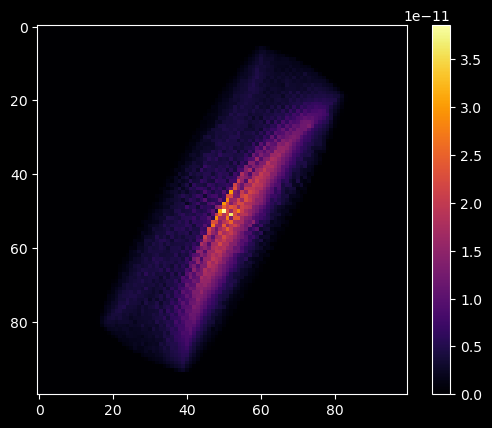

In [135]:
plt.style.use("dark_background")
im = read_image('image.out')
plt.imshow(im)
plt.colorbar()
plt.show()

The main reason why we like to observe protoplanetary disks at mm-wavelengths is because the star is not very bright here, i.e. it does not us glare in our observation. That is different if we go to smaller wavelengths such as the optical (400-700nm) or near-infrared (700nm - 3µm). In these regimes, to expose the protoplanetary disk around a star, the main goal is to remove the star from the image. There are several techniques, one of the most successful one is polarized imaging. Here, one can make use of the fact that direct stellar light is unpolarized, while light gets polarized when it scatters off solid material - such as the dust in PPDs.\
